In [16]:
import json
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [9]:

def clean_text(text):
    for ch in [",", ".", "!", "?", ";", ":", "\"", "'", "(", ")", "_", "-", "/", "\\"]:
        text = text.replace(ch, "")
    return text

def simple_tokenize(text):
    cleaned = clean_text(text)
    return cleaned.split()

def levenshtein_distance(s1, s2):
    m, n = len(s1), len(s2)
    # Initialize DP table
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],   
                                   dp[i][j - 1],   
                                   dp[i - 1][j - 1]) 
    return dp[m][n]

def token_matches(token, aspect):
    
    token_clean = clean_text(token).lower()
    aspect_clean = clean_text(aspect).lower()
    
    if token_clean == aspect_clean:
        return True
    
    if token_clean.endswith('s') and token_clean[:-1] == aspect_clean:
        return True

    if aspect_clean in token_clean:
        return True
    
    # 3. Fuzzy matching using Levenshtein distance.
    threshold = max(1, int(0.2 * len(aspect_clean)))  # Allow ~20% differences.
    distance = levenshtein_distance(token_clean, aspect_clean)
    if distance <= threshold:
        return True

    
    return False


def preprocess_file(input_path, output_path):
    with open(input_path, 'r') as infile:
        data = json.load(infile)
    
    new_data = []
    
    for item in data:
        sentence = item['sentence']
        tokens = simple_tokenize(sentence)
        
        
        for aspect in item.get('aspect_terms', []):
            term = aspect.get('term', "")
            polarity = aspect.get('polarity', "")
            
            term_tokens = simple_tokenize(term)
            aspect_word = term_tokens[0] if term_tokens else term
            
            index = -1
            for i, token in enumerate(tokens):
                if token_matches(token, aspect_word):
                    index = i
                    break
            
            new_instance = {
                "tokens": tokens,
                "polarity": polarity,
                "aspectterm": [term],
                "index": index
            }
            new_data.append(new_instance)
    
    with open(output_path, 'w') as outfile:
        json.dump(new_data, outfile, indent=4)


In [10]:
train_input = '/kaggle/input/a2task2/train.json'
val_input   = '/kaggle/input/a2task2/val.json'

preprocess_file(train_input, 'train_task2.json')
preprocess_file(val_input, 'val_task2.json')

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label2id = {"negative": 0, "neutral": 1, "positive": 2}

class ABSADataset(Dataset):
    def __init__(self, json_path, tokenizer, max_context_len=128, max_aspect_len=16):
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.samples = data
        self.tokenizer = tokenizer
        self.max_context_len = max_context_len
        self.max_aspect_len = max_aspect_len

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        context = " ".join(sample["tokens"])
        if isinstance(sample["aspectterm"], list):
            aspect = " ".join(sample["aspectterm"])
        else:
            aspect = sample["aspectterm"]
        # aspect term is retrieved from the .json not from the tokenized sample itself 
        polarity_str = sample["polarity"]
        label = label2id.get(polarity_str.lower(), 1)  # create mapping
        
        context_enc = self.tokenizer.encode_plus( #using bert
            context,
            add_special_tokens=True,
            max_length=self.max_context_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        aspect_enc = self.tokenizer.encode_plus(     #using bert 
            aspect,
            add_special_tokens=True,
            max_length=self.max_aspect_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        context_input_ids = context_enc['input_ids'].squeeze(0)
        context_attention_mask = context_enc['attention_mask'].squeeze(0)
        aspect_input_ids = aspect_enc['input_ids'].squeeze(0)
        aspect_attention_mask = aspect_enc['attention_mask'].squeeze(0)
        
        return {
            "context_input_ids": context_input_ids,
            "context_attention_mask": context_attention_mask,
            "aspect_input_ids": aspect_input_ids,
            "aspect_attention_mask": aspect_attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }


In [18]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, hidden_states, guide_vector):
        guide = guide_vector.unsqueeze(1)
        projected = self.tanh(self.linear(hidden_states))
        scores = (projected * guide).sum(dim=2)
        weights = self.softmax(scores)
        weighted_sum = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return weighted_sum, weights

In [21]:
class IAN_Model(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_labels, dropout=0.5, cell_type="gru"):
        super(IAN_Model, self).__init__()
        self.bert = bert_model
        self.bert_hidden_size = bert_model.config.hidden_size
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type.lower()
        
        if self.cell_type == "gru":
            self.rnn_context = nn.GRU(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                      num_layers=1, batch_first=True, bidirectional=True)
            self.rnn_aspect = nn.GRU(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                     num_layers=1, batch_first=True, bidirectional=True)
        elif self.cell_type == "lstm":
            self.rnn_context = nn.LSTM(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                       num_layers=1, batch_first=True, bidirectional=True)
            self.rnn_aspect = nn.LSTM(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                      num_layers=1, batch_first=True, bidirectional=True)
        else:
            raise ValueError("Unsupported cell type. Choose 'gru' or 'lstm'.")
        
        self.attention_context = Attention(hidden_dim * 2)
        self.attention_aspect = Attention(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 4, num_labels)
    
    def forward(self, context_input_ids, context_attention_mask, 
                aspect_input_ids, aspect_attention_mask):
        context_outputs = self.bert(input_ids=context_input_ids, attention_mask=context_attention_mask)
        aspect_outputs = self.bert(input_ids=aspect_input_ids, attention_mask=aspect_attention_mask)
        context_embeds = context_outputs.last_hidden_state
        aspect_embeds = aspect_outputs.last_hidden_state
        
        if self.cell_type == "gru":
            context_rnn, _ = self.rnn_context(context_embeds)
            aspect_rnn, _ = self.rnn_aspect(aspect_embeds)
        else:  # lstm
            context_rnn, _ = self.rnn_context(context_embeds)
            aspect_rnn, _ = self.rnn_aspect(aspect_embeds)
        
        context_mask = context_attention_mask.unsqueeze(-1).float()
        aspect_mask = aspect_attention_mask.unsqueeze(-1).float()
        context_sum = torch.sum(context_rnn * context_mask, dim=1)
        aspect_sum = torch.sum(aspect_rnn * aspect_mask, dim=1)
        context_lengths = torch.clamp(torch.sum(context_mask, dim=1), min=1e-9)
        aspect_lengths = torch.clamp(torch.sum(aspect_mask, dim=1), min=1e-9)
        context_pool = context_sum / context_lengths
        aspect_pool = aspect_sum / aspect_lengths
        
        context_final, _ = self.attention_context(context_rnn, aspect_pool)
        aspect_final, _ = self.attention_aspect(aspect_rnn, context_pool)
        final_rep = torch.cat((context_final, aspect_final), dim=1)
        final_rep = self.dropout(final_rep)
        logits = self.fc(final_rep)
        return logits

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        context_input_ids = batch["context_input_ids"].to(device)
        context_attention_mask = batch["context_attention_mask"].to(device)
        aspect_input_ids = batch["aspect_input_ids"].to(device)
        aspect_attention_mask = batch["aspect_attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        logits = model(context_input_ids, context_attention_mask, 
                       aspect_input_ids, aspect_attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in dataloader:
            context_input_ids = batch["context_input_ids"].to(device)
            context_attention_mask = batch["context_attention_mask"].to(device)
            aspect_input_ids = batch["aspect_input_ids"].to(device)
            aspect_attention_mask = batch["aspect_attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            logits = model(context_input_ids, context_attention_mask,
                           aspect_input_ids, aspect_attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

Number of training samples: 2961
Number of validation samples: 371


100%|██████████| 186/186 [01:25<00:00,  2.16it/s]


Epoch 1/10:
  Train Loss: 0.7703, Train Acc: 0.6707
  Val Loss: 0.6798, Val Acc: 0.7197
  Best model updated at epoch 1 with Val Acc: 0.7197


100%|██████████| 186/186 [01:25<00:00,  2.18it/s]


Epoch 2/10:
  Train Loss: 0.5348, Train Acc: 0.7751
  Val Loss: 0.6472, Val Acc: 0.7224
  Best model updated at epoch 2 with Val Acc: 0.7224


100%|██████████| 186/186 [01:25<00:00,  2.17it/s]


Epoch 3/10:
  Train Loss: 0.4132, Train Acc: 0.8352
  Val Loss: 0.6597, Val Acc: 0.7116


100%|██████████| 186/186 [01:25<00:00,  2.17it/s]


Epoch 4/10:
  Train Loss: 0.3436, Train Acc: 0.8642
  Val Loss: 0.7312, Val Acc: 0.6792


100%|██████████| 186/186 [01:25<00:00,  2.18it/s]


Epoch 5/10:
  Train Loss: 0.2569, Train Acc: 0.9014
  Val Loss: 0.7948, Val Acc: 0.7035


100%|██████████| 186/186 [01:25<00:00,  2.17it/s]


Epoch 6/10:
  Train Loss: 0.2160, Train Acc: 0.9227
  Val Loss: 0.8215, Val Acc: 0.6469


100%|██████████| 186/186 [01:25<00:00,  2.18it/s]


Epoch 7/10:
  Train Loss: 0.1596, Train Acc: 0.9392
  Val Loss: 0.8338, Val Acc: 0.6927


100%|██████████| 186/186 [01:25<00:00,  2.17it/s]


Epoch 8/10:
  Train Loss: 0.1396, Train Acc: 0.9510
  Val Loss: 0.9017, Val Acc: 0.6954


100%|██████████| 186/186 [01:25<00:00,  2.18it/s]


Epoch 9/10:
  Train Loss: 0.1138, Train Acc: 0.9612
  Val Loss: 0.9751, Val Acc: 0.6846


100%|██████████| 186/186 [01:25<00:00,  2.18it/s]


Epoch 10/10:
  Train Loss: 0.0829, Train Acc: 0.9710
  Val Loss: 0.9465, Val Acc: 0.7035


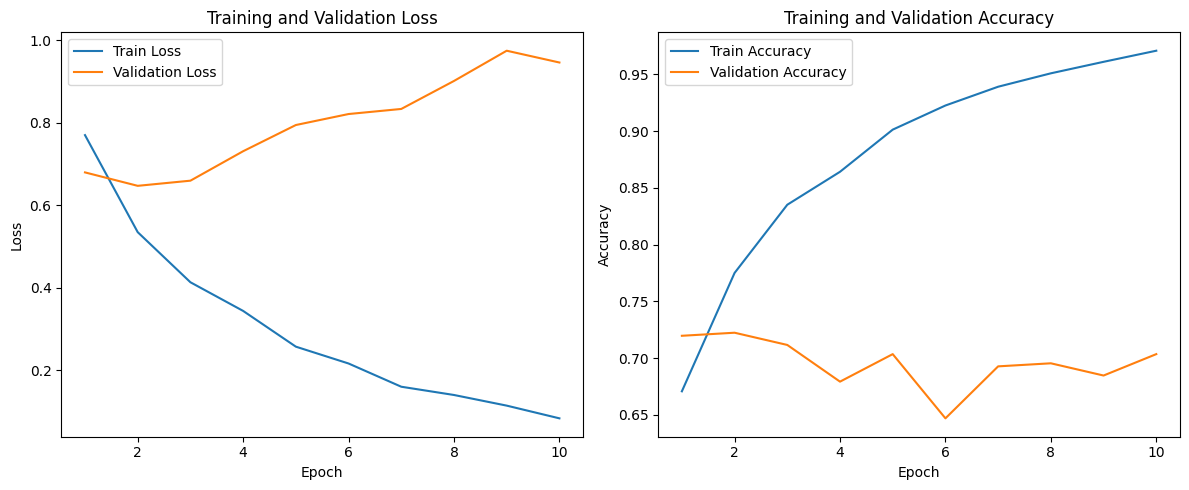

Training complete. Best model (Val Acc: 0.7224) from epoch 2 saved as 'best_model.pt'.


In [22]:
num_epochs = 10
batch_size = 16
learning_rate = 2e-5
hidden_dim = 128
num_labels = 3

cell_type = "gru"  

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.to(device)


train_dataset = ABSADataset("/kaggle/working/train_task2.json", tokenizer)
val_dataset = ABSADataset("/kaggle/working/val_task2.json", tokenizer)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = IAN_Model(bert_model, hidden_dim, num_labels, dropout=0.5, cell_type=cell_type)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

best_val_acc = 0.0
best_epoch = -1

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pt")
        print(f"  Best model updated at epoch {epoch+1} with Val Acc: {val_acc:.4f}")


epochs = np.arange(1, num_epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Training complete. Best model (Val Acc: {best_val_acc:.4f}) from epoch {best_epoch} saved as 'best_model.pt'.")


In [ ]:
import json
import string
import json
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from tqdm import tqdm



def clean_text(text):
    for ch in [",", ".", "!", "?", ";", ":", "\"", "'", "(", ")", "_", "-", "/", "\\"]:
        text = text.replace(ch, "")
    return text

def simple_tokenize(text):
    cleaned = clean_text(text)
    return cleaned.split()

def levenshtein_distance(s1, s2):
    m, n = len(s1), len(s2)
    # Initialize DP table
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],   
                                   dp[i][j - 1],   
                                   dp[i - 1][j - 1]) 
    return dp[m][n]

def token_matches(token, aspect):
    
    token_clean = clean_text(token).lower()
    aspect_clean = clean_text(aspect).lower()
    
    if token_clean == aspect_clean:
        return True
    
    if token_clean.endswith('s') and token_clean[:-1] == aspect_clean:
        return True

    if aspect_clean in token_clean:
        return True
    
    # 3. Fuzzy matching using Levenshtein distance.
    threshold = max(1, int(0.2 * len(aspect_clean)))  # Allow ~20% differences.
    distance = levenshtein_distance(token_clean, aspect_clean)
    if distance <= threshold:
        return True

    
    return False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in dataloader:
            context_input_ids = batch["context_input_ids"].to(device)
            context_attention_mask = batch["context_attention_mask"].to(device)
            aspect_input_ids = batch["aspect_input_ids"].to(device)
            aspect_attention_mask = batch["aspect_attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            logits = model(context_input_ids, context_attention_mask,
                           aspect_input_ids, aspect_attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def preprocess_file(input_path, output_path):
    with open(input_path, 'r') as infile:
        data = json.load(infile)
    
    new_data = []
    
    for item in data:
        sentence = item['sentence']
        tokens = simple_tokenize(sentence)
        
        
        for aspect in item.get('aspect_terms', []):
            term = aspect.get('term', "")
            polarity = aspect.get('polarity', "")
            
            term_tokens = simple_tokenize(term)
            aspect_word = term_tokens[0] if term_tokens else term
            
            index = -1
            for i, token in enumerate(tokens):
                if token_matches(token, aspect_word):
                    index = i
                    break
            
            new_instance = {
                "tokens": tokens,
                "polarity": polarity,
                "aspectterm": [term],
                "index": index
            }
            new_data.append(new_instance)
    
    with open(output_path, 'w') as outfile:
        json.dump(new_data, outfile, indent=4)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

senitment_mapping = {"negative": 0, "neutral": 1, "positive": 2}

class ABSADataset(Dataset):
    def __init__(self, json_path, tokenizer, max_context_len=128, max_aspect_len=16):
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.samples = data
        self.tokenizer = tokenizer
        self.max_context_len = max_context_len
        self.max_aspect_len = max_aspect_len

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        context = " ".join(sample["tokens"])
        if isinstance(sample["aspectterm"], list):
            aspect = " ".join(sample["aspectterm"])
        else:
            aspect = sample["aspectterm"]
        # aspect term is retrieved from the .json not from the tokenized sample itself 
        polarity_str = sample["polarity"]
        label = senitment_mapping.get(polarity_str.lower(), 1)  # create mapping
        
        context_enc = self.tokenizer.encode_plus(    #using bert
            context,
            add_special_tokens=True,
            max_length=self.max_context_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        aspect_enc = self.tokenizer.encode_plus(     #using bert 
            aspect,
            add_special_tokens=True,
            max_length=self.max_aspect_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        context_input_ids = context_enc['input_ids'].squeeze(0)
        context_attention_mask = context_enc['attention_mask'].squeeze(0)
        aspect_input_ids = aspect_enc['input_ids'].squeeze(0)
        aspect_attention_mask = aspect_enc['attention_mask'].squeeze(0)
        
        return {
            "context_input_ids": context_input_ids,
            "context_attention_mask": context_attention_mask,
            "aspect_input_ids": aspect_input_ids,
            "aspect_attention_mask": aspect_attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }

        
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, hidden_states, guide_vector):
        guide = guide_vector.unsqueeze(1)
        projected = self.tanh(self.linear(hidden_states))
        scores = (projected * guide).sum(dim=2)
        weights = self.softmax(scores)
        weighted_sum = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return weighted_sum, weights
    
    


class IAN_Model(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_labels, dropout=0.5, cell_type="gru"):
        super(IAN_Model, self).__init__()
        self.bert = bert_model
        self.bert_hidden_size = bert_model.config.hidden_size
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type.lower()
        
        if self.cell_type == "gru":
            self.rnn_context = nn.GRU(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                      num_layers=1, batch_first=True, bidirectional=True)              # bidirectional encodings 
            self.rnn_aspect = nn.GRU(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                     num_layers=1, batch_first=True, bidirectional=True)               # bidirectional encodings
        elif self.cell_type == "lstm":
            self.rnn_context = nn.LSTM(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                       num_layers=1, batch_first=True, bidirectional=True)
            self.rnn_aspect = nn.LSTM(input_size=self.bert_hidden_size, hidden_size=hidden_dim,
                                      num_layers=1, batch_first=True, bidirectional=True)
        else:
            raise ValueError("Unsupported cell type. Choose 'gru' or 'lstm'.")
        
        self.attention_context = Attention(hidden_dim * 2)
        self.attention_aspect = Attention(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 4, num_labels)
    
    def forward(self, context_input_ids, context_attention_mask, 
                aspect_input_ids, aspect_attention_mask):
        context_outputs = self.bert(input_ids=context_input_ids, attention_mask=context_attention_mask)
        aspect_outputs = self.bert(input_ids=aspect_input_ids, attention_mask=aspect_attention_mask)
        context_embeds = context_outputs.last_hidden_state
        aspect_embeds = aspect_outputs.last_hidden_state
        
        if self.cell_type == "gru":
            context_rnn, _ = self.rnn_context(context_embeds)
            aspect_rnn, _ = self.rnn_aspect(aspect_embeds)
        else: 
            context_rnn, _ = self.rnn_context(context_embeds)
            aspect_rnn, _ = self.rnn_aspect(aspect_embeds)
        
        context_mask = context_attention_mask.unsqueeze(-1).float()
        aspect_mask = aspect_attention_mask.unsqueeze(-1).float()
        context_sum = torch.sum(context_rnn * context_mask, dim=1)
        aspect_sum = torch.sum(aspect_rnn * aspect_mask, dim=1)
        context_lengths = torch.clamp(torch.sum(context_mask, dim=1), min=1e-9)    # clamps all elements in input into the range [ min , max ] 
        aspect_lengths = torch.clamp(torch.sum(aspect_mask, dim=1), min=1e-9)
        context_pool = context_sum / context_lengths
        aspect_pool = aspect_sum / aspect_lengths
        
        context_final, _ = self.attention_context(context_rnn, aspect_pool)
        aspect_final, _ = self.attention_aspect(aspect_rnn, context_pool)
        final_rep = torch.cat((context_final, aspect_final), dim=1)
        final_rep = self.dropout(final_rep)
        logits = self.fc(final_rep)
        return logits


def test_function(model_path, test_json_path):
    preprocess_file(test_json_path , 'test_tokenized.json')
    test_tokenized_path = 'test_tokenized.json'
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")
    bert_model.to(device)
    
    hidden_dim = 128
    num_labels = 3
    cell_type = "gru" 
    model = IAN_Model(bert_model, hidden_dim, num_labels, dropout=0.5, cell_type=cell_type)   #The implementation of IAN_Model is given above
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    

    test_dataset = ABSADataset(test_tokenized_path , tokenizer)             #Its implementations should be run before executing this cell 
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    

    criterion = nn.CrossEntropyLoss()
    
    
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return test_acc

test_accuracy = test_function("best_model.pt", "test.json")


<ipython-input-26-88b082c25cb4>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Loss: 0.6472, Test Accuracy: 0.7224


In [ ]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import (BertTokenizer, BertForSequenceClassification, 
                          BartTokenizer, BartForSequenceClassification, 
                          RobertaTokenizer, RobertaForSequenceClassification,
                          AdamW)
import numpy as np
from tqdm import tqdm


compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}

class AspectSentimentDataset(Dataset):
    def __init__(self, file_path, tokenizer_model, sequence_length=128):
        with open(file_path, 'r') as file:
            self.data_samples = json.load(file)
        self.tokenizer_model = tokenizer_model
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data_samples)
    
    def __getitem__(self, index):
        current_sample = self.data_samples[index]
       
        full_text = " ".join(current_sample["tokens"])
        
        aspect_term = current_sample["aspectterm"][0]
        sentiment_text = current_sample["polarity"]
        sentiment_id = sentiment_mapping.get(sentiment_text.lower(), 1)  
        

        token_data = self.tokenizer_model.encode_plus(
            text=full_text,
            text_pair=aspect_term,
            add_special_tokens=True,
            max_length=self.sequence_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        result_dict = {
            "input_ids": token_data["input_ids"].squeeze(0),
            "attention_mask": token_data["attention_mask"].squeeze(0),
            "label": torch.tensor(sentiment_id, dtype=torch.long)
        }
        if "token_type_ids" in token_data:
            result_dict["token_type_ids"] = token_data["token_type_ids"].squeeze(0)
        return result_dict

def initialize_model_components(model_name, label_count=3):
    model_name = model_name.lower()
    if model_name == "bert":
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=label_count)
    elif model_name == "bart":
        tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
        model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=label_count)
    elif model_name == "roberta":
        tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=label_count)
    else:
        raise ValueError("Unsupported model_name. Please select from 'bert', 'bart', or 'roberta'.")
    return tokenizer, model


def perform_training(model, data_loader, optimizer, device):
    model.train()
    cumulative_loss = 0.0
    correct_predictions = 0
    sample_count = 0
    
    for batch_data in data_loader:
        optimizer.zero_grad()
        
        
        model_inputs = {
            "input_ids": batch_data["input_ids"].to(device),
            "attention_mask": batch_data["attention_mask"].to(device),
            "labels": batch_data["label"].to(device)
        }
        if "token_type_ids" in batch_data:
            model_inputs["token_type_ids"] = batch_data["token_type_ids"].to(device)
            
       
        output = model(**model_inputs)
        batch_loss = output.loss
        predictions = output.logits
        
        
        batch_loss.backward()
        optimizer.step()
        
        
        batch_size = model_inputs["labels"].size(0)
        cumulative_loss += batch_loss.item() * batch_size
        prediction_labels = torch.argmax(predictions, dim=1)
        correct_predictions += (prediction_labels == model_inputs["labels"]).sum().item()
        sample_count += batch_size
        
   
    epoch_loss = cumulative_loss / sample_count
    epoch_accuracy = correct_predictions / sample_count
    return epoch_loss, epoch_accuracy

def assess_performance(model, data_loader, device):
    model.eval()
    cumulative_loss = 0.0
    correct_predictions = 0
    sample_count = 0
    
    with torch.no_grad():
        for batch_data in tqdm(data_loader):
            model_inputs = {
                "input_ids": batch_data["input_ids"].to(device),
                "attention_mask": batch_data["attention_mask"].to(device),
                "labels": batch_data["label"].to(device)
            }
            if "token_type_ids" in batch_data:
                model_inputs["token_type_ids"] = batch_data["token_type_ids"].to(device)
                
            
            output = model(**model_inputs)
            batch_loss = output.loss
            predictions = output.logits
            
            
            batch_size = model_inputs["labels"].size(0)
            cumulative_loss += batch_loss.item() * batch_size
            prediction_labels = torch.argmax(predictions, dim=1)
            correct_predictions += (prediction_labels == model_inputs["labels"]).sum().item()
            sample_count += batch_size
            
    
    epoch_loss = cumulative_loss / sample_count
    epoch_accuracy = correct_predictions / sample_count
    return epoch_loss, epoch_accuracy

def visualize_results(epoch_nums, train_loss_history, val_loss_history, 
                     train_acc_history, val_acc_history, model_variant):
    plt.figure(figsize=(12, 5))
    
   
    plt.subplot(1, 2, 1)
    plt.plot(epoch_nums, train_loss_history, 'b-', label="Training Loss")
    plt.plot(epoch_nums, val_loss_history, 'r-', label="Validation Loss")
    plt.xlabel("Training Epoch")
    plt.ylabel("Loss Value")
    plt.title(f"{model_variant.upper()} - Loss Progression")
    plt.legend()
    
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_nums, train_acc_history, 'b-', label="Training Accuracy")
    plt.plot(epoch_nums, val_acc_history, 'r-', label="Validation Accuracy")
    plt.xlabel("Training Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_variant.upper()} - Accuracy Progression")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{model_variant}_performance_charts.png")
    plt.show()


def run_experiment():
    transformer_models = ["bert", "bart", "roberta"]
    
    for model_idx, model_variant in enumerate(transformer_models):
        epochs_to_train = 10
        samples_per_batch = 16
        optimizer_lr = 2e-5
        max_seq_length = 128  
        
        
        tokenizer_model, model_instance = initialize_model_components(model_variant, label_count=3)
        model_instance.to(compute_device)
        
        
        training_set = AspectSentimentDataset("/kaggle/working/train_task2.json", 
                                            tokenizer_model, sequence_length=max_seq_length)
        validation_set = AspectSentimentDataset("/kaggle/working/val_task2.json", 
                                              tokenizer_model, sequence_length=max_seq_length)
        
        print(f"Dataset stats for {model_variant.upper()}: Training={len(training_set)}, Validation={len(validation_set)}")
        
        
        training_loader = DataLoader(training_set, batch_size=samples_per_batch, shuffle=True)
        validation_loader = DataLoader(validation_set, batch_size=samples_per_batch, shuffle=False)
        
        
        optimizer = AdamW(model_instance.parameters(), lr=optimizer_lr)
        
        
        highest_val_accuracy = 0.0
        best_model_epoch = 0
        train_loss_history, train_accuracy_history = [], []
        val_loss_history, val_accuracy_history = [], []
        
        
    
        for epoch_num in range(epochs_to_train):
           
            train_epoch_loss, train_epoch_acc = perform_training(
                model_instance, training_loader, optimizer, compute_device)
            
            
            val_epoch_loss, val_epoch_acc = assess_performance(
                model_instance, validation_loader, compute_device)
            
            
            train_loss_history.append(train_epoch_loss)
            train_accuracy_history.append(train_epoch_acc)
            val_loss_history.append(val_epoch_loss)
            val_accuracy_history.append(val_epoch_acc)
            
            
            print(f"Epoch {epoch_num+1}/{epochs_to_train} Results:")
            print(f"Train Loss:{train_epoch_loss:.4f}, Train Acc:{train_epoch_acc:.4f}")
            print(f"Val Loss:{val_epoch_loss:.4f}, Val Acc:{val_epoch_acc:.4f}")
            
            
            if val_epoch_acc > highest_val_accuracy:
                highest_val_accuracy = val_epoch_acc
                best_model_epoch = epoch_num + 1
                torch.save(model_instance.state_dict(), f"best_{model_variant}_model.pt")
                print(f"Best model updated at epoch {epoch_num+1} with Val Acc: {val_epoch_acc:.4f})")
        
        
        print(f"\n{model_variant.upper()} Training Complete!")
        print(f"Best model achieved {highest_val_accuracy:.4f} validation accuracy at epoch {best_model_epoch}")
        print(f"Model saved as 'best_{model_variant}_model.pt'")
        
        
        epoch_range = np.arange(1, epochs_to_train+1)
        visualize_results(epoch_range, train_loss_history, val_loss_history, 
                         train_accuracy_history, val_accuracy_history, model_variant)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training samples: 2961, Validation samples: 371


100%|██████████| 24/24 [00:02<00:00,  8.52it/s]


Epoch 1/10:
  Train Loss: 0.7904, Train Acc: 0.6548
  Val Loss: 0.7004, Val Acc: 0.7062
  Best model updated at epoch 1 with Val Acc: 0.7062


100%|██████████| 24/24 [00:02<00:00,  8.48it/s]


Epoch 2/10:
  Train Loss: 0.5273, Train Acc: 0.7788
  Val Loss: 0.5756, Val Acc: 0.7682
  Best model updated at epoch 2 with Val Acc: 0.7682


100%|██████████| 24/24 [00:02<00:00,  8.53it/s]


Epoch 3/10:
  Train Loss: 0.3583, Train Acc: 0.8544
  Val Loss: 0.5872, Val Acc: 0.7439


100%|██████████| 24/24 [00:02<00:00,  8.49it/s]


Epoch 4/10:
  Train Loss: 0.2295, Train Acc: 0.9159
  Val Loss: 0.6959, Val Acc: 0.7547


100%|██████████| 24/24 [00:02<00:00,  8.49it/s]


Epoch 5/10:
  Train Loss: 0.1430, Train Acc: 0.9520
  Val Loss: 0.7980, Val Acc: 0.7601


100%|██████████| 24/24 [00:02<00:00,  8.50it/s]


Epoch 6/10:
  Train Loss: 0.1066, Train Acc: 0.9656
  Val Loss: 0.9108, Val Acc: 0.7628


100%|██████████| 24/24 [00:02<00:00,  8.53it/s]


Epoch 7/10:
  Train Loss: 0.0675, Train Acc: 0.9770
  Val Loss: 1.0384, Val Acc: 0.7170


100%|██████████| 24/24 [00:02<00:00,  8.51it/s]


Epoch 8/10:
  Train Loss: 0.0656, Train Acc: 0.9797
  Val Loss: 0.9573, Val Acc: 0.7547


100%|██████████| 24/24 [00:02<00:00,  8.41it/s]


Epoch 9/10:
  Train Loss: 0.0610, Train Acc: 0.9801
  Val Loss: 1.0296, Val Acc: 0.7682


100%|██████████| 24/24 [00:02<00:00,  8.50it/s]


Epoch 10/10:
  Train Loss: 0.0593, Train Acc: 0.9804
  Val Loss: 0.9437, Val Acc: 0.7466
Training complete. Best model (Val Acc: 0.7682) from epoch 2 saved as 'best_model_bert.pt'.


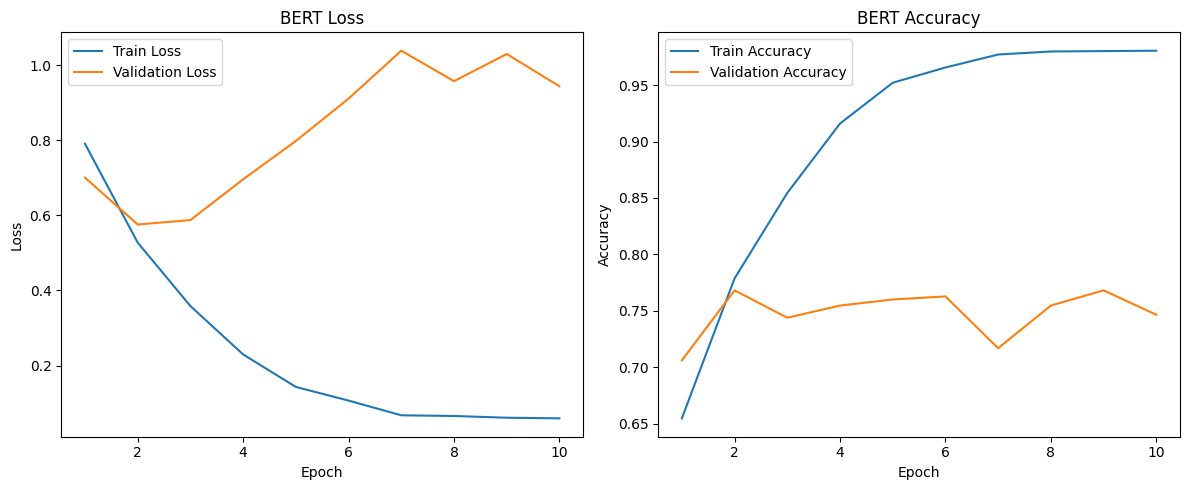

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training samples: 2961, Validation samples: 371


100%|██████████| 24/24 [00:03<00:00,  7.32it/s]


Epoch 1/10:
  Train Loss: 0.7733, Train Acc: 0.6643
  Val Loss: 0.6662, Val Acc: 0.6954
  Best model updated at epoch 1 with Val Acc: 0.6954


100%|██████████| 24/24 [00:03<00:00,  7.35it/s]


Epoch 2/10:
  Train Loss: 0.5507, Train Acc: 0.7768
  Val Loss: 0.5899, Val Acc: 0.7412
  Best model updated at epoch 2 with Val Acc: 0.7412


100%|██████████| 24/24 [00:03<00:00,  7.32it/s]


Epoch 3/10:
  Train Loss: 0.4273, Train Acc: 0.8386
  Val Loss: 0.6102, Val Acc: 0.7143


100%|██████████| 24/24 [00:03<00:00,  7.34it/s]


Epoch 4/10:
  Train Loss: 0.3641, Train Acc: 0.8622
  Val Loss: 0.6402, Val Acc: 0.7332


100%|██████████| 24/24 [00:03<00:00,  7.31it/s]


Epoch 5/10:
  Train Loss: 0.3603, Train Acc: 0.8629
  Val Loss: 0.7244, Val Acc: 0.7547
  Best model updated at epoch 5 with Val Acc: 0.7547


100%|██████████| 24/24 [00:03<00:00,  7.34it/s]


Epoch 6/10:
  Train Loss: 0.3871, Train Acc: 0.8497
  Val Loss: 0.7210, Val Acc: 0.7520


100%|██████████| 24/24 [00:03<00:00,  7.30it/s]


Epoch 7/10:
  Train Loss: 0.3374, Train Acc: 0.8696
  Val Loss: 0.8287, Val Acc: 0.7709
  Best model updated at epoch 7 with Val Acc: 0.7709


100%|██████████| 24/24 [00:03<00:00,  7.35it/s]


Epoch 8/10:
  Train Loss: 0.3026, Train Acc: 0.8875
  Val Loss: 0.7758, Val Acc: 0.7439


100%|██████████| 24/24 [00:03<00:00,  7.31it/s]


Epoch 9/10:
  Train Loss: 0.2295, Train Acc: 0.9105
  Val Loss: 0.8049, Val Acc: 0.7736
  Best model updated at epoch 9 with Val Acc: 0.7736


100%|██████████| 24/24 [00:03<00:00,  7.31it/s]


Epoch 10/10:
  Train Loss: 0.1963, Train Acc: 0.9210
  Val Loss: 0.8587, Val Acc: 0.7574
Training complete. Best model (Val Acc: 0.7736) from epoch 9 saved as 'best_model_bart.pt'.


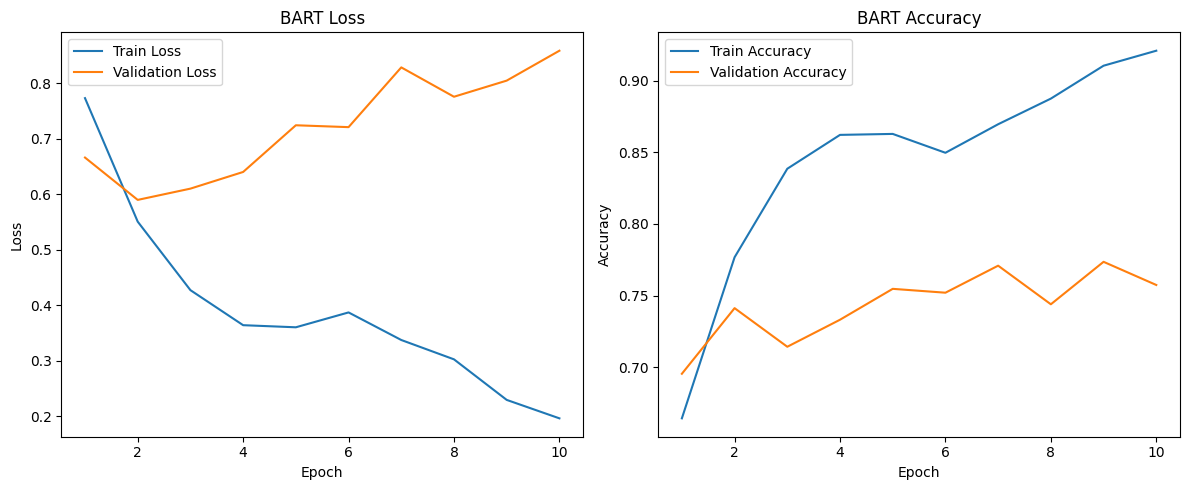

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training samples: 2961, Validation samples: 371


100%|██████████| 24/24 [00:02<00:00,  9.49it/s]


Epoch 1/10:
  Train Loss: 0.7542, Train Acc: 0.6798
  Val Loss: 0.6880, Val Acc: 0.7062
  Best model updated at epoch 1 with Val Acc: 0.7062


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 2/10:
  Train Loss: 0.5050, Train Acc: 0.7950
  Val Loss: 0.6221, Val Acc: 0.7520
  Best model updated at epoch 2 with Val Acc: 0.7520


100%|██████████| 24/24 [00:02<00:00,  9.50it/s]


Epoch 3/10:
  Train Loss: 0.3417, Train Acc: 0.8652
  Val Loss: 0.7405, Val Acc: 0.7493


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Epoch 4/10:
  Train Loss: 0.2406, Train Acc: 0.9112
  Val Loss: 0.7126, Val Acc: 0.7116


100%|██████████| 24/24 [00:02<00:00,  9.46it/s]


Epoch 5/10:
  Train Loss: 0.1740, Train Acc: 0.9358
  Val Loss: 0.7533, Val Acc: 0.7682
  Best model updated at epoch 5 with Val Acc: 0.7682


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch 6/10:
  Train Loss: 0.1280, Train Acc: 0.9541
  Val Loss: 0.8638, Val Acc: 0.7574


100%|██████████| 24/24 [00:02<00:00,  9.50it/s]


Epoch 7/10:
  Train Loss: 0.0969, Train Acc: 0.9669
  Val Loss: 0.8137, Val Acc: 0.7682


100%|██████████| 24/24 [00:02<00:00,  9.47it/s]


Epoch 8/10:
  Train Loss: 0.0806, Train Acc: 0.9750
  Val Loss: 0.8934, Val Acc: 0.7790
  Best model updated at epoch 8 with Val Acc: 0.7790


100%|██████████| 24/24 [00:02<00:00,  9.47it/s]


Epoch 9/10:
  Train Loss: 0.0512, Train Acc: 0.9811
  Val Loss: 1.3162, Val Acc: 0.7224


100%|██████████| 24/24 [00:02<00:00,  9.46it/s]


Epoch 10/10:
  Train Loss: 0.0598, Train Acc: 0.9791
  Val Loss: 1.0600, Val Acc: 0.7547
Training complete. Best model (Val Acc: 0.7790) from epoch 8 saved as 'best_model_roberta.pt'.


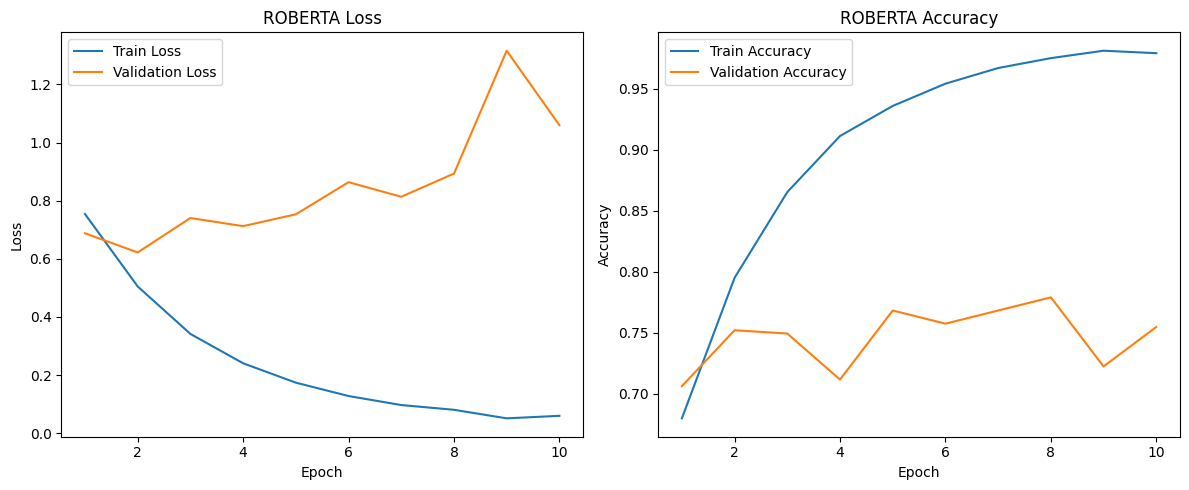

In [ ]:
run_experiment()